In [2]:
#MLP to predict next char in sequence. 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for figs
%matplotlib inline

In [4]:
words = open('../lecture 2/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
#building the vocab of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [82]:
#let's build the dataset
block_size = 3 #context length: how many chars do we take to predict the next one?
X,Y = [], []
for w in words:
    #print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [12]:
X.shape, X.dtype, Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [15]:
#27 possible chars, embed them in a lower dimensional space. each one of our 27 chars will have a 2D embedding
C = torch.randn((27,2))

In [17]:
C[5]

tensor([-0.0332,  0.9312])

In [22]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C #THIS IS THE SAME RESULT BECAUSE OF HOW MATMUL WORKS! ITS AN ELEMENTWISE MULTIPLICATION OF EACH ROW. THE ONEHOT VECTOR IS JUST 
                                                      #ALL ZEROS AND A 1 FOR THE CORRESPONDING NUMBER, SO THE MATMUL WE DO HERE JUST MASKS OUT THE ENTIRE THING EXCEPT FOR THE ELEMENT WE WANT
                                                      #We won't do this because its completely unneccesary but my third eye has been opened

tensor([-0.0332,  0.9312])

In [26]:
C[torch.tensor([5,6,7,7,7,7])] #this is just to show that you can index into a pytorch tensor with a different tensor, which is why the following works:

tensor([[-0.0332,  0.9312],
        [-0.3310, -0.3674],
        [-0.7762,  0.3578],
        [-0.7762,  0.3578],
        [-0.7762,  0.3578],
        [-0.7762,  0.3578]])

In [28]:
C[X] #oh my god

tensor([[[ 1.2954,  1.7474],
         [ 1.2954,  1.7474],
         [ 1.2954,  1.7474]],

        [[ 1.2954,  1.7474],
         [ 1.2954,  1.7474],
         [-0.0332,  0.9312]],

        [[ 1.2954,  1.7474],
         [-0.0332,  0.9312],
         [ 1.0514,  0.6870]],

        [[-0.0332,  0.9312],
         [ 1.0514,  0.6870],
         [ 1.0514,  0.6870]],

        [[ 1.0514,  0.6870],
         [ 1.0514,  0.6870],
         [ 0.0270, -0.5449]],

        [[ 1.2954,  1.7474],
         [ 1.2954,  1.7474],
         [ 1.2954,  1.7474]],

        [[ 1.2954,  1.7474],
         [ 1.2954,  1.7474],
         [ 0.4848,  0.0448]],

        [[ 1.2954,  1.7474],
         [ 0.4848,  0.0448],
         [-1.2501,  0.2089]],

        [[ 0.4848,  0.0448],
         [-1.2501,  0.2089],
         [-0.0754,  0.6725]],

        [[-1.2501,  0.2089],
         [-0.0754,  0.6725],
         [ 1.5591, -0.2297]],

        [[-0.0754,  0.6725],
         [ 1.5591, -0.2297],
         [-0.0754,  0.6725]],

        [[ 1.5591, -0

In [29]:
C[X].shape

torch.Size([32, 3, 2])

In [30]:
X[13,2]

tensor(1)

In [31]:
C[X][13,2]

tensor([ 0.0270, -0.5449])

In [32]:
C[1]

tensor([ 0.0270, -0.5449])

In [33]:
#Pytorch embedding is awesome. 
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [34]:
W1 = torch.randn((6,100)) #100 neurons
b1 = torch.randn(100)

In [35]:
emb @ W1 + b1 #doesn't work currently, dimensional issues

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [40]:
torch.cat([emb[:,0,:],  emb[:,0,:], emb[:,0,:]],1).shape

torch.Size([32, 6])

In [43]:
#now our embeddings have the dim we want, but its hideous, we're putting values in directly and it will not work if we decide to change the length of our context window (its currently 3)
torch.cat(torch.unbind(emb,1), 1).shape #this is better than the first one. its still inefficient because it creates a new tensor and a whole bunch of new memory

torch.Size([32, 6])

In [44]:
#calling .view() is extremely efficient due to shadow magic purposes. 
emb.shape

torch.Size([32, 3, 2])

In [46]:
emb.view(32,6)  == torch.cat(torch.unbind(emb,1), 1)#this is basically the concatenation operation  we were looking for

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [50]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #this works now!  (putting in -1 in the first arg of .view( ) makes pytorch infer what dimension this should have. neat)

In [51]:
h.shape

torch.Size([32, 100])

In [52]:
h

tensor([[ 1.0000, -0.9831, -1.0000,  ...,  0.6218,  0.9995,  0.9831],
        [ 0.9979, -0.9708, -0.9993,  ..., -0.9920,  0.9962,  0.5110],
        [ 0.9932, -0.9901, -0.9917,  ..., -0.2425,  0.0420,  0.9939],
        ...,
        [-1.0000, -0.7140,  0.9987,  ..., -0.9702, -1.0000,  0.9810],
        [ 1.0000, -0.5822,  0.9607,  ..., -0.9951,  0.9975, -1.0000],
        [-0.9996,  0.9237, -0.7924,  ...,  0.9998, -0.9896, -0.4349]])

In [55]:
#a note on broadcasting and making sure that it works
print((emb.view(-1,6)@W1).shape)
print(b1.shape)
#We basically have 
# 32,100
#  1,100 , this creates a "fake" dimension of 1 to make the addition possible. 100 aligns with 100, we're good. good practice to check broadcasting semantics

torch.Size([32, 100])
torch.Size([100])


In [56]:
W2 = torch.randn((100,27)) #27 neurons, this is the final layer of our network
b2 = torch.randn(27)
logits = h @ W2 + b2

In [57]:
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp()

In [59]:
prob = counts / counts.sum(1, keepdims = True)

In [60]:
#Previous two steps was our softmax
prob.shape

torch.Size([32, 27])

In [61]:
prob[0].sum() #checking that softmax has worked

tensor(1.)

In [63]:
#we have the actual layer that comes next. it comes from Y, which is the identity of the next char that we wanna predict. we wanna index into the rows of prob and each row, we'd like to pluck
#out the probablility assigned to the next character
prob[torch.arange(32),Y]

tensor([1.5128e-04, 1.2007e-10, 3.5098e-11, 3.1889e-01, 1.3862e-06, 1.5810e-02,
        4.0860e-08, 1.3941e-02, 1.3443e-09, 1.5657e-04, 1.2827e-04, 1.2321e-05,
        4.0182e-02, 1.0797e-10, 8.5287e-06, 1.0124e-08, 2.5105e-03, 7.7306e-09,
        8.4083e-08, 6.6667e-04, 1.5578e-05, 4.9395e-19, 1.0184e-13, 2.8138e-07,
        4.9146e-10, 3.6064e-04, 1.1044e-01, 6.1107e-11, 6.6895e-14, 6.6118e-10,
        3.0271e-03, 2.4734e-13])

In [64]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(15.2922)

In [83]:
#Rewrite to make more respectable
X.shape, Y.shape #Dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [84]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [85]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

3481

In [86]:
for p in parameters:
    p.requires_grad = True

In [89]:
#This is basically very bad crossentropy. we just use the torch function instead. explained a bit more in the cell below this one 
logits_test = torch.tensor([-5,-3,0,5]) + 1#too positives of values give inf, we get out of our range exponentiating like this. you can add an arbitrary constant to all of ur logits. prebuilt crossentropy does this for ur most positive logit to make sure we don't get such a large count that its infintie
counts_t = logits_test.exp()
probs_T = counts_t / counts_t.sum()
probs_T

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [88]:
for _ in range(10):
#forward pass: prebuilt crossentropy instead of doing it this awful way:
    emb = C[X] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print("Final:" + str(loss.item()))

9.14895248413086
8.93111801147461
8.722238540649414
8.521757125854492
8.329233169555664
8.144330978393555
7.966796875
7.7964558601379395
7.633191108703613
7.4769134521484375
Final:7.4769134521484375


In [170]:
#we overfit one batch in the example above. before when initialising out X and Y, we had words[:5], we're gonna get rid of the slicing and just use the entire dataset. 
#Once we did train on the entire dataset in one go, as we saw above, it was incredibly slow. around a second per epoch, which is bad if we want thousands. 
#we gotta do batching. rewriting model below so we have both versions for educational purposes
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [171]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

3481

In [172]:
for p in parameters:
    p.requires_grad = True

In [173]:
#below we figured out through trial and error that the best LR is prolly between 0.001 and 1. lets use that as a search space
lrE= torch.linspace(-3,0,1000)
lrs = 10**lrE

In [178]:
lri = []
lossi = []
for i in range(100000):
#forward pass: prebuilt crossentropy instead of doing it this awful way, AND WITH BATCHING :) 

    #mninibatch construct
    ix = torch.randint(0,X.shape[0], (32,)) #generates 32 random numbers between 0 and the highest val number in X. indices that we will pass into C[x] below to grab 32 random examples from our dataset   
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix]) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update, but with learning rate indexing over our linear jumps over the exponents of our learning rate range
    #lr = lrs[i]
    lr = 0.01 #we did a search for the best LR and found that its exponent was optimal at -1, so we know that 0.1 is a pretty good learning rate. we do a LR decay after running a couple 10 thousand of each LR. 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats to find best LR
    #lri.append(lrE[i])
    #lossi.append(loss.item())

print("Final:" + str(loss.item()))

Final:2.3828396797180176


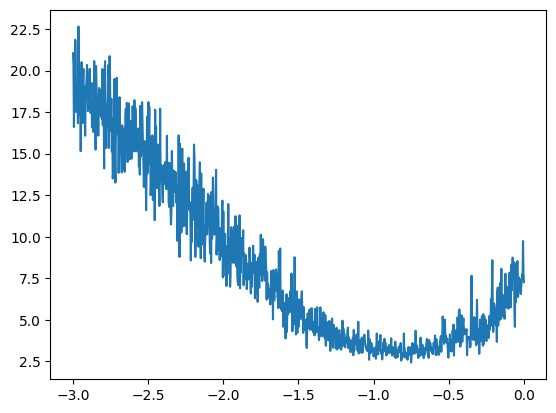

In [164]:
plt.plot(lri,lossi)

In [179]:
#above is the loss for only one minibatch. let's evaluate for all of X and all of Y
emb = C[X]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Y)
loss

tensor(2.2218, grad_fn=<NllLossBackward0>)

In [ ]:
#now obviously we haven't done a train test split. this is bad. 
#training split, dev/validation split, test split
#80%, 10%, 10%
#80% is used to optimize parameters, validation split is used to optimize hyperparameters, test split is for testing